### IMPORT REQUIRED LIBRARIES

In [2]:
import pandas as pd
import numpy as np
from scipy import stats

import pandas_datareader as pdr
from datetime import datetime

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

import matplotlib.pyplot as plt
import seaborn as sns
import math
from numpy import log

from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools


### LOAD DATA

In [4]:
path = "yahoo_stock.csv"
df = pd.read_csv(path, parse_dates = ['Date'], index_col = 'Date')

In [5]:
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-11-23,2095.610107,2081.389893,2089.409912,2086.590088,3.587980e+09,2086.590088
2015-11-24,2094.120117,2070.290039,2084.419922,2089.139893,3.884930e+09,2089.139893
2015-11-25,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
2015-11-26,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
2015-11-27,2093.290039,2084.129883,2088.820068,2090.110107,1.466840e+09,2090.110107
...,...,...,...,...,...,...
2020-11-16,3628.510010,3600.159912,3600.159912,3626.909912,5.281980e+09,3626.909912
2020-11-17,3623.110107,3588.679932,3610.310059,3609.530029,4.799570e+09,3609.530029
2020-11-18,3619.090088,3567.330078,3612.090088,3567.790039,5.274450e+09,3567.790039


There are six columns given:

**High** -> Highest Price of the stock for that particular date.

**Low** -> Lowest Price of the stock for that particular date.

**Open** -> Opening Price of the stock.

**Close** -> Closing Price of the stock.

**Volume** -> Total amount of Trading Activity.

**AdjClose** -> Adjusted values factor in corporate actions such as dividends, stock splits, and new share issuance.

### BASIC STATISTICS

In [ ]:
df.shape

(1825, 6)

* Dataset contains 6 columns of indicators and date column

In [ ]:
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.iloc[0].values
    summary['Second Value'] = df.iloc[1].values
    summary['Third Value'] = df.iloc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary

In [ ]:
resumetable(df)

Dataset Shape: (1825, 6)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,High,float64,0,1252,2.095610e+03,2.094120e+03,2.093000e+03,10.07
1,Low,float64,0,1251,2.081390e+03,2.070290e+03,2.086300e+03,10.07
2,Open,float64,0,1247,2.089410e+03,2.084420e+03,2.089300e+03,10.07
3,Close,float64,0,1252,2.086590e+03,2.089140e+03,2.088870e+03,10.07
4,Volume,float64,0,1258,3.587980e+09,3.884930e+09,2.852940e+09,10.08
5,Adj Close,float64,0,1252,2.086590e+03,2.089140e+03,2.088870e+03,10.07


# ANALYSIS B

## PRELIMINARY ANALYSIS

* Let us plot four of the indicators by different colors.

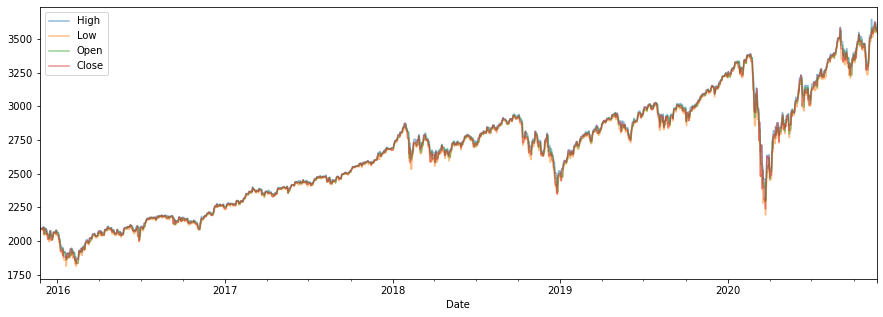

In [ ]:
df[['High','Low','Open','Close']].plot(figsize = (15, 5), alpha = 0.5)

* We notice that there are no huge variations in the Open-Close prices and the High-Low prices over the given time. These four have almost same behavior over the time. (Based on this assumption, here we will focus on one of them - 'Close' in order to build a model which could predict future values.)

* We observe 2 huge dips in the stock prices, once around 2019 (possibly due to Brexit) and other in March 2020 (owing to the Covid-19 Pandemic).

* There is an overall increase in the stock price from 2017 to 2018.

* Let us first check if this time-series corresponds to Stationary type, which characterizes:

Constant variance
Constant mean
No Seasonality
No autocorrelation


### INDICATOR DISTRIBUTION

<ipython-input-12-34ac8fbc4937>:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  hist=df.hist(ax=ax)


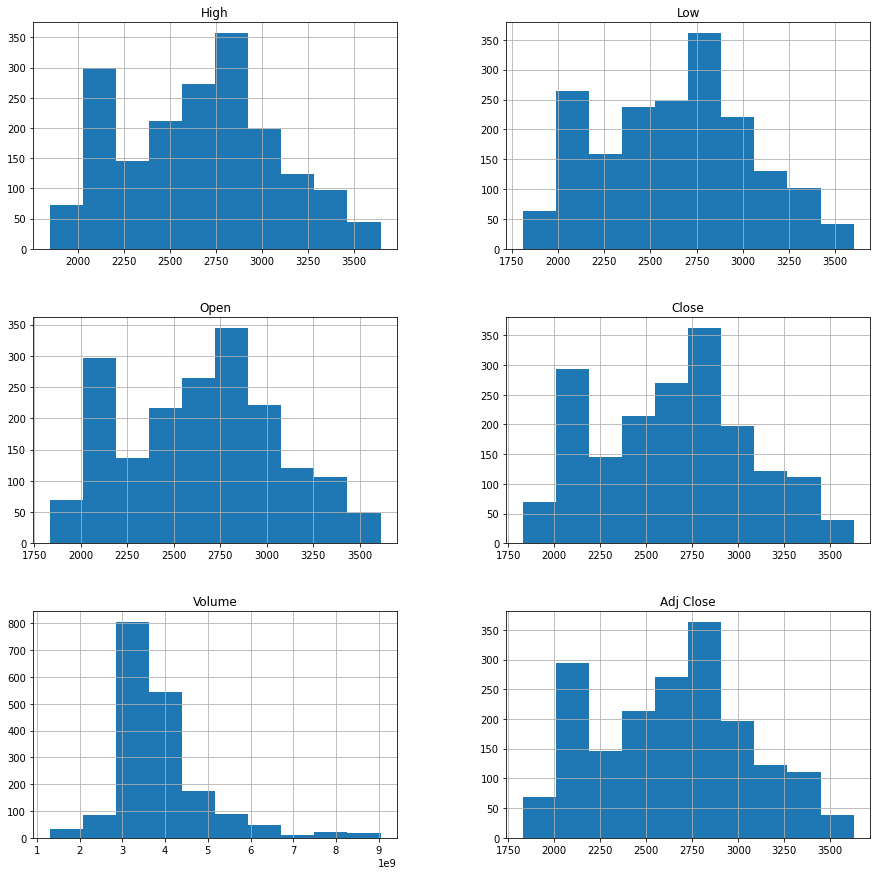

In [ ]:
fig = plt.figure(figsize = (15, 15))
ax = fig.gca()
hist=df.hist(ax=ax)

* The distribution of indicators is not entirely normal.

### CORRELATION

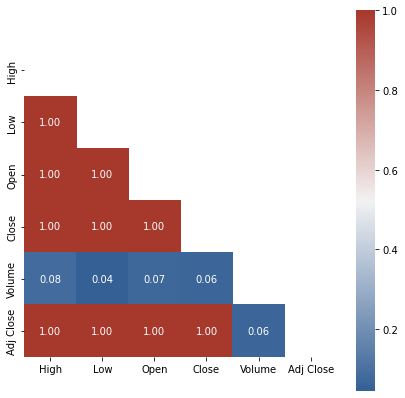

In [ ]:
# Create a custom palette
cmap = sns.diverging_palette(250, 15, s=75, l=40, n=9, center="light", as_cmap=True)

# Compute corr matrix
matrix = df.corr(method="pearson")

mask = np.triu(np.ones_like(matrix, dtype=bool))

#plot
fig, ax = plt.subplots(figsize=(7, 7))
sns.heatmap(matrix, mask=mask, cmap=cmap, square=True, annot=True, fmt=".2f", ax=ax)
plt.show();

* Correlation does not mean causation

When two features are heavily correlated, it does not mean an increase in one causes an increase in another.

### CALCULATE RSI

The Relative Strength Index (RSI) calculates a ratio of the recent upward price movements to the absolute price movement. Developed by J. Welles Wilder.

The RSI calculation is RSI = 100 - 100 / ( 1 + RS ), where RS is the smoothed ratio of 'average' gains over 'average' losses. The 'averages' aren't true averages, since they're divided by the value of n and not the number of periods in which there are gains/losses.

source: RStudio

In [ ]:
url = 'https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files'
ext = '0.4.0-oneiric1_amd64.deb -qO'
!wget $url/libta-lib0_$ext libta.deb
!wget $url/ta-lib0-dev_$ext ta.deb
!dpkg -i libta.deb ta.deb
!pip install ta-lib
import talib

Selecting previously unselected package libta-lib0.
(Reading database ... 124015 files and directories currently installed.)
Preparing to unpack libta.deb ...
Unpacking libta-lib0 (0.4.0-oneiric1) ...
Selecting previously unselected package ta-lib0-dev.
Preparing to unpack ta.deb ...
Unpacking ta-lib0-dev (0.4.0-oneiric1) ...
Setting up libta-lib0 (0.4.0-oneiric1) ...
Setting up ta-lib0-dev (0.4.0-oneiric1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Processing triggers for libc-bin (2.27-3ubuntu1.6) ...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 271 kB 5.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for ta-lib: filename=TA_Lib-0.4.25-cp38-cp38-linux_x86_64.whl size=1820859 sha256=3cd12641d1ae8e2185e96734aa729ba6973ebe9d8ada3848e004e

In [ ]:
df_rsi = df.copy()
df_rsi['RSI'] = talib.RSI(df_rsi['Close'])

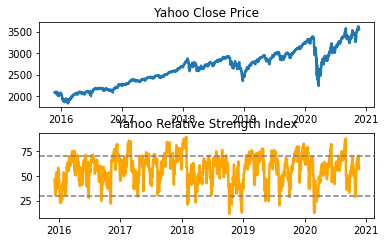

In [ ]:
ax1 = plt.subplot2grid((10,1), (0,0), rowspan = 4, colspan = 1)
ax2 = plt.subplot2grid((10,1), (5,0), rowspan = 4, colspan = 1)
ax1.plot(df_rsi['Close'], linewidth = 2.5)
ax1.set_title('Yahoo Close Price')
ax2.plot(df_rsi['RSI'], color = 'orange', linewidth = 2.5)
ax2.axhline(30, linestyle = '--', linewidth = 1.5, color = 'grey')
ax2.axhline(70, linestyle = '--', linewidth = 1.5, color = 'grey')
ax2.set_title('Yahoo Relative Strength Index')
plt.show()

* When the RSI line goes below the bottom line (30), BUY, when it goes above the top line (70), sell.

### STATIONARITY CHECK

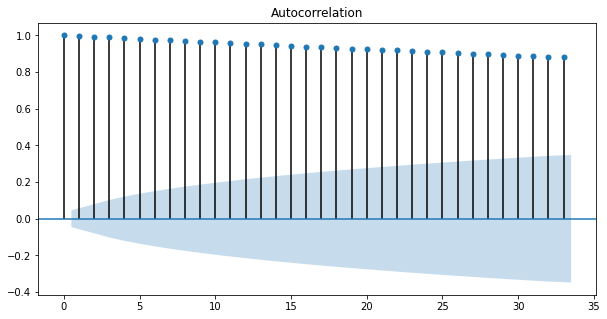

In [ ]:
plt.rc("figure", figsize=(10,5))
plot_acf(df['Close'])
print()

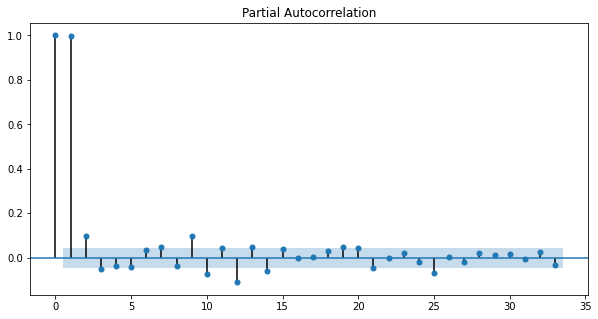

In [ ]:
plt.rc("figure", figsize=(10,5))
plot_pacf(df['Close'])
print()

In [ ]:
test = adfuller(df['Close'])
print('ADF Statistic: %f' % test[0])
print('p-value: %f' % test[1])
print('Critical Values:')
for key, value in test[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.870397
p-value: 0.797565
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


* We observe the p-value greater than 0.05. Therefore, we fail to reject the null hypothesis of non-stationary series. 

* Let us take the log transformation to the series and perform test again.

In [ ]:
test = adfuller(log(df['Close']))
print('ADF Statistic: %f' % test[0])
print('p-value: %f' % test[1])
print('Critical Values:')
for key, value in test[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.130203
p-value: 0.702878
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


* Looking at the above test results, we can confirm that the given series  corresponds to a non-stationary series, meaning we may need to convert this to stationary by performing some transformations. 

* Note: Deep Learning models can be performed on non-stationary series to predict future values, however they take more time to train these models.

## MODELLING

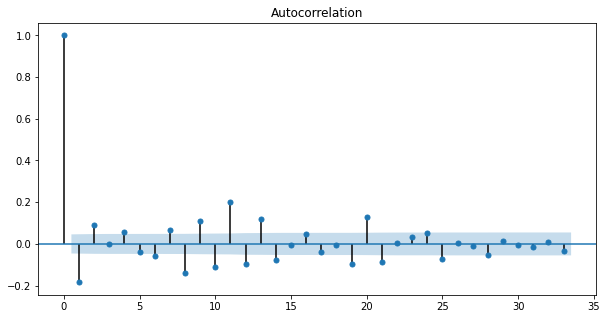

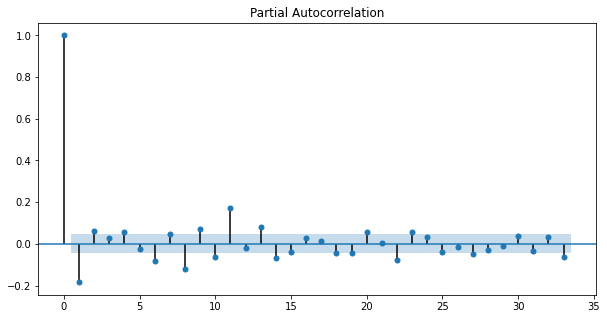

In [ ]:
plt.rc("figure", figsize=(10,5))
plot_acf(log(df['Close']).diff().dropna())
plot_pacf(log(df['Close']).diff().dropna())
plt.show()

We aggregate the data from daily to monthly in order to carry out the analysis as working with daily data can be cumbersome. Plotting the series give the following results

Text(0.5, 1.0, 'Monthly Average Time Series Plot of Log of Closing Prices')

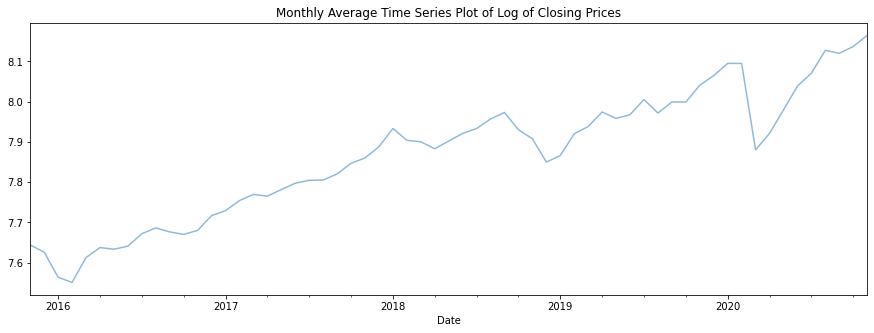

In [ ]:
df_close_mon_avg = log(df['Close']).resample('MS').mean()
df_close_mon_avg.plot(figsize = (15, 5), alpha = 0.5)
plt.title('Monthly Average Time Series Plot of Log of Closing Prices')

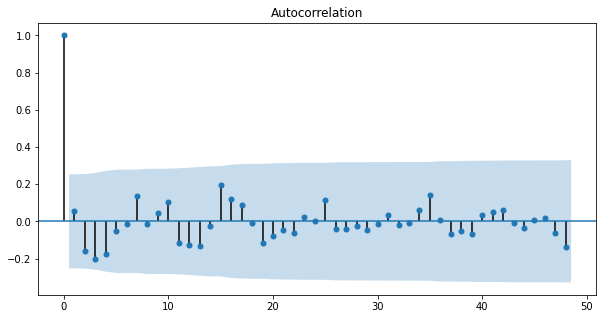

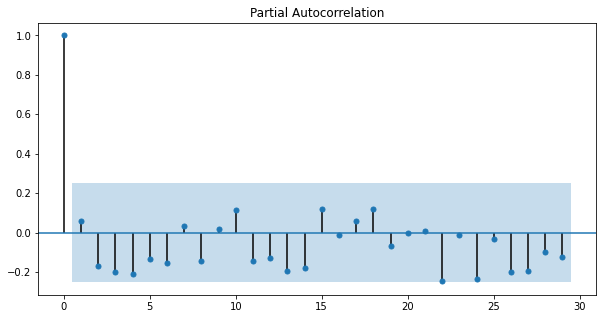

In [ ]:
df_close_mon_diff = df_close_mon_avg.diff()
plt.rc("figure", figsize=(10,5))
plot_acf(df_close_mon_diff.dropna(), lags=48)
plot_pacf(df_close_mon_diff.dropna(), lags=29)
plt.show()

We notice that there are seasonal spikes at lag = 12 in the above plots. So let's checkout the ACF and PACF plots after performing the seasonal differencing on the abpve series.

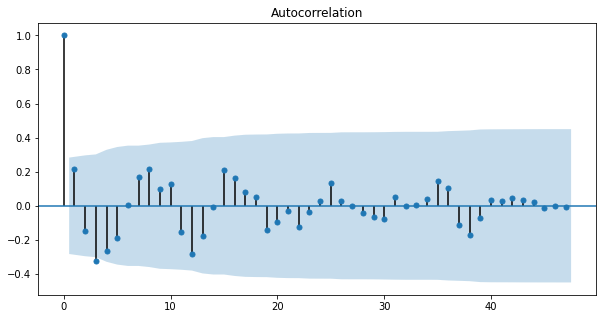

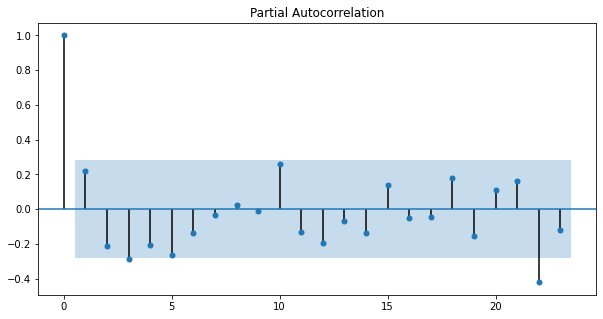

In [ ]:
df_close_s_diff = df_close_mon_diff.dropna().diff(12)
plt.rc("figure", figsize=(10,5))
plot_acf(df_close_s_diff.dropna(), lags=47)
plot_pacf(df_close_s_diff.dropna(), lags=23)
plt.show()

We can see that –

* Non-seasonal: From the plots, we note that ACF is cutting off after lag=2 and 

* PACF is tailing off which means this is a probable AR order of 2 model with differencing. Therefore, p=2, q=0, d=1.
Seasonal: From the seasonal part of the above plots, we see that both ACF and PACF are tailing off and this could be an ARMA model with differencing. We could say the seasonal parameters to be P=1 or 2, Q=1 or 2, D=1


So, our probable SARIMA model equation can be –

**SARIMA(2,0,1)x(1,1,1)12**

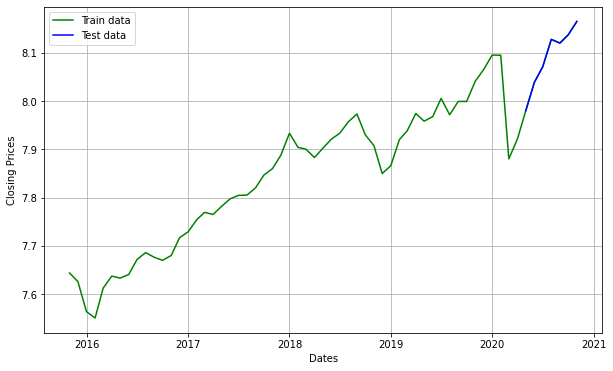

In [ ]:
df_log = df_close_mon_avg
train_data, test_data = df_log[:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [ ]:

mod = SARIMAX(train_data,
              order=(2, 1, 0),
              seasonal_order=(1, 1, 1, 12))
model = mod.fit(method = 'powell')
print(model.summary())

Optimization terminated successfully.
         Current function value: -1.196630
         Iterations: 4
         Function evaluations: 292
                                      SARIMAX Results                                       
Dep. Variable:                                Close   No. Observations:                   54
Model:             SARIMAX(2, 1, 0)x(1, 1, [1], 12)   Log Likelihood                  64.618
Date:                              Mon, 05 Dec 2022   AIC                           -119.236
Time:                                      05:01:38   BIC                           -110.668
Sample:                                  11-01-2015   HQIC                          -116.116
                                       - 04-01-2020                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------

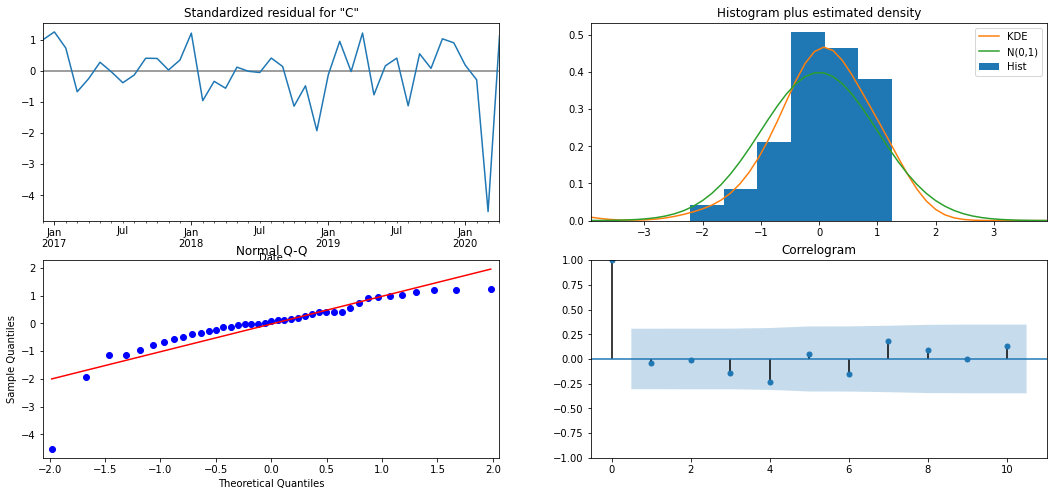

In [ ]:
model.plot_diagnostics(figsize=(18, 8))
plt.show()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


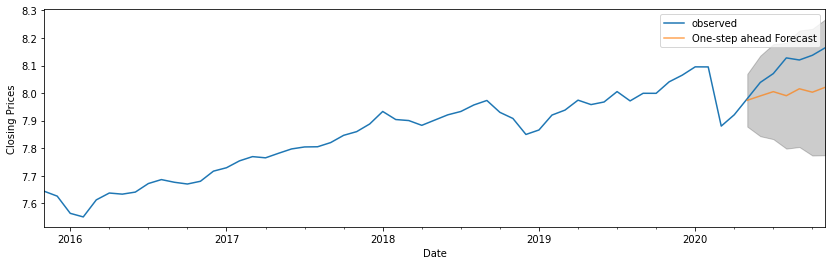

In [ ]:
pred = model.get_prediction(start='2020-05-01', end='2020-11-01', dynamic=False)
pred_ci = pred.conf_int()
ax = df_log.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Closing Prices')
plt.legend()
plt.show()

In [ ]:
y_forecasted = pred.predicted_mean
y_truth = df_log['2020-05-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error is 0.01
The Root Mean Squared Error is 0.1


In [ ]:
# report performance
mse = mean_squared_error(test_data, y_forecasted)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, y_forecasted)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(y_forecasted)))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(np.exp(y_forecasted) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: '+str(mape))

MSE: 0.010717065850590873
MAE: 0.09136980494811274
RMSE: 331.2430867405861
MAPE: 0.08622986635947003


In [ ]:

p = range(0, 3)
d = range(1,2)
q = range(0, 4)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
seasonal_pdq


In [ ]:

results = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(train_data,
                          order=param,
                          seasonal_order=param_seasonal,
                  )
            model = mod.fit(method = 'powell')
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, model.aic))
            results.append((param, param_seasonal, model.aic))
        except:
            continue

NameError: ignored

In [ ]:
result_df = pd.DataFrame(results)
result_df.columns = ['PDQ', 'Seasonal_PDQ', 'AIC']
result_df['AIC'] = result_df['AIC'].round(2)
#Sort in ascending order, lower AIC is better
result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
result_df.head()

In [ ]:
mod = SARIMAX(train_data,
              order=(2, 1, 2),
              seasonal_order=(0, 1, 0, 12))
model = mod.fit(method = 'powell')
print(model.summary())

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Optimization terminated successfully.
         Current function value: -1.289245
         Iterations: 14
         Function evaluations: 1031
                                      SARIMAX Results                                      
Dep. Variable:                               Close   No. Observations:                   54
Model:             SARIMAX(2, 1, 2)x(0, 1, [], 12)   Log Likelihood                  69.619
Date:                             Mon, 05 Dec 2022   AIC                           -129.238
Time:                                     05:02:04   BIC                           -120.671
Sample:                                 11-01-2015   HQIC                          -126.119
                                      - 04-01-2020                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------

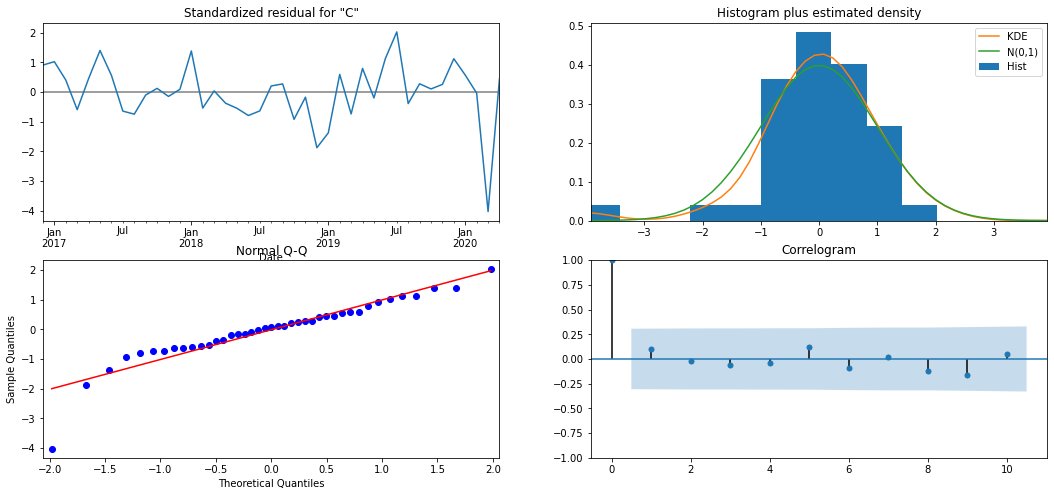

In [ ]:
model.plot_diagnostics(figsize=(18, 8))
plt.show()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


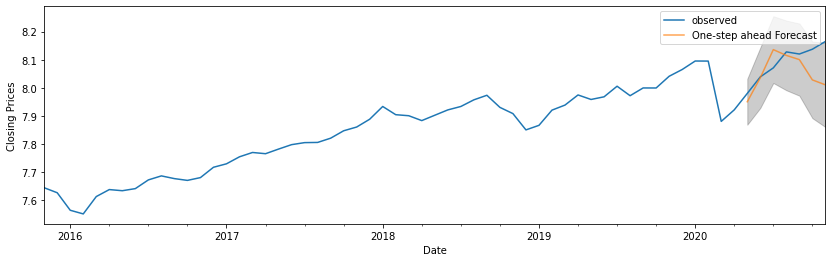

In [ ]:
pred = model.get_prediction(start='2020-05-01', end='2020-11-01', dynamic=False)
pred_ci = pred.conf_int()
ax = df_log.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Closing Prices')
plt.legend()
plt.show()


In [ ]:
y_forecasted = pred.predicted_mean
y_truth = df_log['2020-05-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error is 0.01
The Root Mean Squared Error is 0.08


In [ ]:

# report performance
mse = mean_squared_error(test_data, y_forecasted)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, y_forecasted)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(y_forecasted)))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(np.exp(y_forecasted) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: '+str(mape))

MSE: 0.005924152556226808
MAE: 0.0562707582785669
RMSE: 250.20716054006056
MAPE: 0.054034613690130524


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Optimization terminated successfully.
         Current function value: -1.295163
         Iterations: 13
         Function evaluations: 955
                                      SARIMAX Results                                      
Dep. Variable:                               Close   No. Observations:                   61
Model:             SARIMAX(2, 1, 2)x(0, 1, [], 12)   Log Likelihood                  79.005
Date:                             Mon, 05 Dec 2022   AIC                           -148.010
Time:                                     05:02:21   BIC                           -138.654
Sample:                                 11-01-2015   HQIC                          -144.474
                                      - 11-01-2020                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


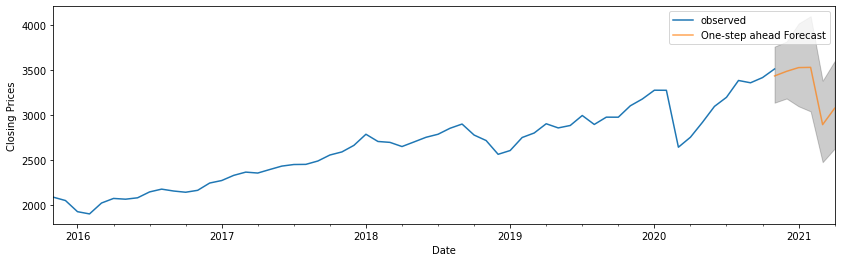

In [ ]:
mod = SARIMAX(df_log,
              order=(2, 1, 2),
              seasonal_order=(0, 1, 0, 12))
model = mod.fit(method = 'powell')
print(model.summary())


pred = model.get_prediction(start='2020-11-01', end='2021-04-01', dynamic=False)
pred_ci = pred.conf_int()
ax = np.exp(df_log).plot(label='observed')
np.exp(pred.predicted_mean).plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between(pred_ci.index,
                np.exp(pred_ci.iloc[:, 0]),
                np.exp(pred_ci.iloc[:, 1]), color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Closing Prices')
plt.legend()
plt.show()

In [ ]:
np.exp(pred.predicted_mean[1:]).to_frame('Close').reset_index()

,index,Close
0,2020-12-01,3488.938597
1,2021-01-01,3530.712014
2,2021-02-01,3533.412648
3,2021-03-01,2895.889640
4,2021-04-01,3077.882051


# ANALYSIS C

In [ ]:
close_series = df.Close

In [ ]:
WINDOW = 10
PRED_LENGTH = int(WINDOW/2)
def get_reg_train_test(timeseries,sequence_length= 51,
                   train_size=0.9,roll_mean_window=5,
                   normalize=True,scale=False):
    # smoothen out series
    if roll_mean_window:
        timeseries = timeseries.rolling(roll_mean_window).mean().dropna()
    
    # create windows
    result = []
    for index in range(len(timeseries) - sequence_length):
        result.append(timeseries[index: index + sequence_length])
           
    
    # # normalize data as a variation of 0th index
    # if normalize:
    #     normalised_data = []
    #     for window in result:
    #         normalised_window = [((float(p) / float(window[0])) - 1) \
    #                                for p in window]
    #         normalised_data.append(normalised_window)
    #     result = normalised_data
    
    # identify train-test splits
    result = np.array(result) 
    row = round(train_size * result.shape[0])
    
    # split train and test sets
    train = result[:int(row), :]
    test = result[int(row):, :]
    
    # scale data in 0-1 range
    scaler = None
    if scale:
        scaler=MinMaxScaler(feature_range=(0, 1))
        train = scaler.fit_transform(train)
        test = scaler.transform(test)
    
      
    # split independent and dependent variables  
    x_train = train[:, :-1]
    y_train = train[:, -1]
        
        
    x_test = test[:, :-1]
    y_test = test[:, -1]
    
    # Transforms for LSTM input
    x_train = np.reshape(x_train, (x_train.shape[0], 
                                   x_train.shape[1], 
                                   1))
    x_test = np.reshape(x_test, (x_test.shape[0], 
                                 x_test.shape[1], 
                                 1)) 
    
    return x_train,y_train,x_test,y_test,scaler

In [ ]:
x_train,y_train,x_test,y_test,scaler = get_reg_train_test(close_series,
                                                      sequence_length=WINDOW+1,
                                                      roll_mean_window=None,
                                                      normalize=True,
                                                      scale=False)
    
print("Data Split Complete")

print("x_train shape={}".format(x_train.shape))
print("y_train shape={}".format(y_train.shape))
print("x_test shape={}".format(x_test.shape))
print("y_test shape={}".format(y_test.shape))

Data Split Complete
x_train shape=(1633, 10, 1)
y_train shape=(1633,)
x_test shape=(181, 10, 1)
y_test shape=(181,)


### LSTM MODELING

### MODEL 1:
Window size= 10, stacked architecture

In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [ ]:
from keras.layers.core import Dense, Activation, Dropout
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
import pandas as pd

# fix random seed for reproducibility
tf.random.set_seed(7)
path="/content/gdrive/MyDrive/Stat-429_Project/yahoo_stock.csv"
df = pd.read_csv(path, parse_dates = ['Date'], index_col = 'Date')


dataset = df.Close.to_frame().values
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split into train and test sets
train_size = int(len(dataset) * 0.9)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# reshape into X=t and Y=t+1
look_back = 10
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# # reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(100, input_shape=(look_back, 1), return_sequences=True))
model.add(LSTM(100))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
#model.compile(loss="mse", optimizer="rmsprop")

model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

# make predictions
trainPredict = model.predict(trainX, batch_size=1)
# model.reset_states()
testPredict = model.predict(testX, batch_size=1)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])


Epoch 1/100
1631/1631 - 14s - loss: 0.0019 - 14s/epoch - 9ms/step
Epoch 2/100
1631/1631 - 15s - loss: 8.1680e-04 - 15s/epoch - 9ms/step
Epoch 3/100
1631/1631 - 17s - loss: 4.9224e-04 - 17s/epoch - 11ms/step
Epoch 4/100
1631/1631 - 12s - loss: 4.4124e-04 - 12s/epoch - 7ms/step
Epoch 5/100
1631/1631 - 12s - loss: 4.3213e-04 - 12s/epoch - 7ms/step
Epoch 6/100
1631/1631 - 11s - loss: 4.2693e-04 - 11s/epoch - 7ms/step
Epoch 7/100
1631/1631 - 11s - loss: 4.1728e-04 - 11s/epoch - 7ms/step
Epoch 8/100
1631/1631 - 13s - loss: 3.9872e-04 - 13s/epoch - 8ms/step
Epoch 9/100
1631/1631 - 11s - loss: 3.6536e-04 - 11s/epoch - 7ms/step
Epoch 10/100
1631/1631 - 11s - loss: 3.6490e-04 - 11s/epoch - 7ms/step
Epoch 11/100
1631/1631 - 11s - loss: 3.3588e-04 - 11s/epoch - 7ms/step
Epoch 12/100
1631/1631 - 11s - loss: 3.1854e-04 - 11s/epoch - 7ms/step
Epoch 13/100
1631/1631 - 12s - loss: 3.4769e-04 - 12s/epoch - 7ms/step
Epoch 14/100
1631/1631 - 12s - loss: 3.3346e-04 - 12s/epoch - 7ms/step
Epoch 15/100
1631/

In [ ]:
# calculate root mean squared error
trainScore_mape = mean_absolute_percentage_error(trainY[0], trainPredict[:,0])
trainScore_rmse = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f MAPE' % (trainScore_mape))
print('Train Score: %.2f RMSE' % (trainScore_rmse))

testScore_mape = mean_absolute_percentage_error(testY[0], testPredict[:,0])
testScore_rmse = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f MAPE' % (testScore_mape))
print('Test Score: %.2f RMSE' % (testScore_rmse))

# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

NameError: ignored

### MODEL 2

Window size= 5, stacked architecture

In [ ]:
from keras.layers.core import Dense, Activation, Dropout

# fix random seed for reproducibility
tf.random.set_seed(7)
path="/content/gdrive/MyDrive/Stat-429_Project/yahoo_stock.csv"
df = pd.read_csv(path, parse_dates = ['Date'], index_col = 'Date')


dataset = df.Close.to_frame().values
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split into train and test sets
train_size = int(len(dataset) * 0.9)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# reshape into X=t and Y=t+1
look_back = 5
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# # reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(100, input_shape=(look_back, 1), return_sequences=True))
model.add(LSTM(100))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2, shuffle=False)

# make predictions
trainPredict = model.predict(trainX, batch_size=1)
# model.reset_states()
testPredict = model.predict(testX, batch_size=1)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])


In [ ]:
# calculate root mean squared error
trainScore_mape = mean_absolute_percentage_error(trainY[0], trainPredict[:,0])
trainScore_rmse = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f MAPE' % (trainScore_mape))
print('Train Score: %.2f RMSE' % (trainScore_rmse))

testScore_mape = mean_absolute_percentage_error(testY[0], testPredict[:,0])
testScore_rmse = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f MAPE' % (testScore_mape))
print('Test Score: %.2f RMSE' % (testScore_rmse))

# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

### MODEL 3
Window size= 10, Single layer architecture

In [ ]:
dataset = df.Close.to_frame().values
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split into train and test sets
train_size = int(len(dataset) * 0.9)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# reshape into X=t and Y=t+1
look_back = 10
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# # reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

# create and fit the LSTM network
model = Sequential()
# model.add(LSTM(100, input_shape=(look_back, 1), return_sequences=True))
model.add(LSTM(100, input_shape=(look_back, 1)))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2, shuffle=False)

# make predictions
trainPredict = model.predict(trainX, batch_size=1)
# model.reset_states()
testPredict = model.predict(testX, batch_size=1)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])


Epoch 1/100
1631/1631 - 9s - loss: 7.4905e-04 - 9s/epoch - 6ms/step
Epoch 2/100
1631/1631 - 7s - loss: 9.6055e-04 - 7s/epoch - 4ms/step
Epoch 3/100
1631/1631 - 8s - loss: 0.0010 - 8s/epoch - 5ms/step
Epoch 4/100
1631/1631 - 8s - loss: 0.0011 - 8s/epoch - 5ms/step
Epoch 5/100
1631/1631 - 8s - loss: 0.0012 - 8s/epoch - 5ms/step
Epoch 6/100
1631/1631 - 8s - loss: 0.0012 - 8s/epoch - 5ms/step
Epoch 7/100
1631/1631 - 8s - loss: 0.0011 - 8s/epoch - 5ms/step
Epoch 8/100
1631/1631 - 8s - loss: 9.6214e-04 - 8s/epoch - 5ms/step
Epoch 9/100
1631/1631 - 8s - loss: 7.3481e-04 - 8s/epoch - 5ms/step
Epoch 10/100
1631/1631 - 8s - loss: 5.7689e-04 - 8s/epoch - 5ms/step
Epoch 11/100
1631/1631 - 8s - loss: 4.7052e-04 - 8s/epoch - 5ms/step
Epoch 12/100
1631/1631 - 8s - loss: 3.9934e-04 - 8s/epoch - 5ms/step
Epoch 13/100
1631/1631 - 8s - loss: 3.6036e-04 - 8s/epoch - 5ms/step
Epoch 14/100
1631/1631 - 8s - loss: 3.3661e-04 - 8s/epoch - 5ms/step
Epoch 15/100
1631/1631 - 8s - loss: 3.3079e-04 - 8s/epoch - 5ms

Train Score: 0.03 MAPE
Train Score: 88.96 RMSE
Test Score: 0.07 MAPE
Test Score: 263.62 RMSE


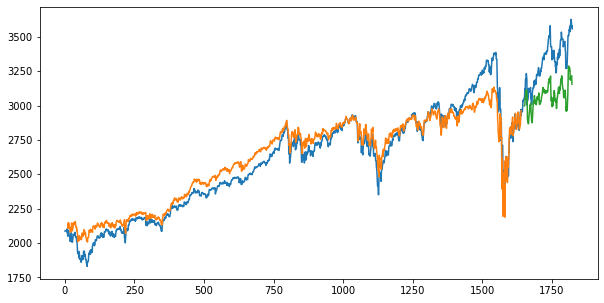

In [ ]:
# calculate root mean squared error
trainScore_mape = mean_absolute_percentage_error(trainY[0], trainPredict[:,0])
trainScore_rmse = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f MAPE' % (trainScore_mape))
print('Train Score: %.2f RMSE' % (trainScore_rmse))

testScore_mape = mean_absolute_percentage_error(testY[0], testPredict[:,0])
testScore_rmse = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f MAPE' % (testScore_mape))
print('Test Score: %.2f RMSE' % (testScore_rmse))

# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()